In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import keras.layers as layers
warnings.filterwarnings(action='ignore')

# 데이터 Load 및 시각화

In [2]:
train_dir = 'data/ex_05/train'
test_dir = 'data/ex_05/test'

In [59]:
IMG_SIZE  = (160,160)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  batch_size  = 32,
  image_size=IMG_SIZE,
  seed=123)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  batch_size  = 32,
  image_size=IMG_SIZE,
  seed=123)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  batch_size  = 32,
  image_size=IMG_SIZE,
  shuffle=False,
  seed=123)
    
    

Found 300 files belonging to 3 classes.
Using 240 files for training.
Found 300 files belonging to 3 classes.
Using 60 files for validation.
Found 300 files belonging to 3 classes.


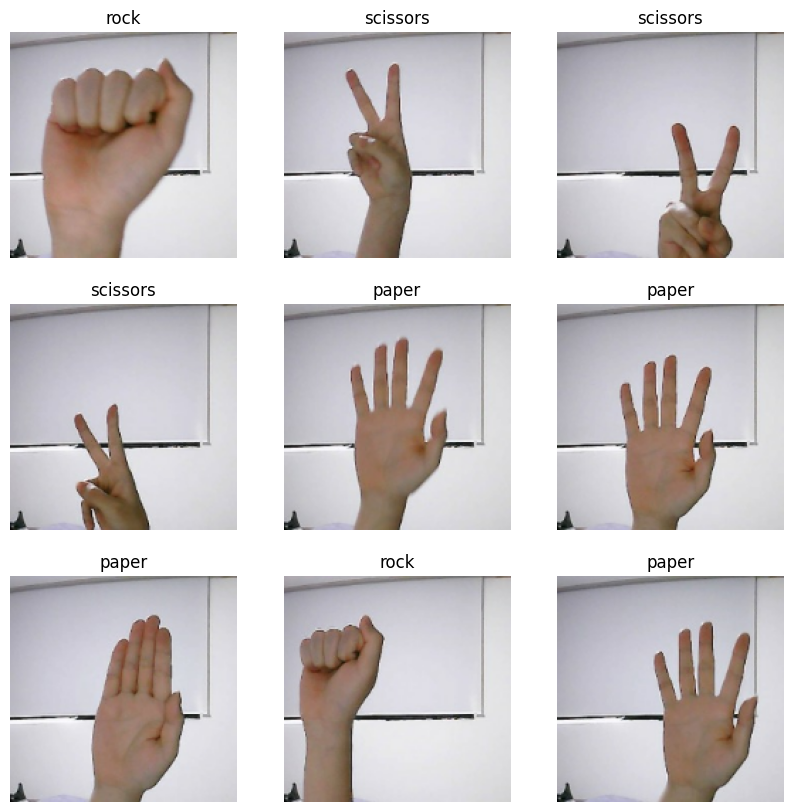

In [4]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 데이터 정규화 및 증강 MobileNetV2를 활용한 Transfer learning

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10


2023-04-10 09:42:18.043929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


8/8 [==============================] - 4s 157ms/step - loss: 1.0758 - accuracy: 0.4875 - val_loss: 0.8290 - val_accuracy: 0.5167
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 0.5784 - accuracy: 0.7750 - val_loss: 0.3580 - val_accuracy: 0.9167
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 0.3141 - accuracy: 0.9042 - val_loss: 0.1796 - val_accuracy: 0.9333
Epoch 4/10
8/8 [==============================] - 0s 36ms/step - loss: 0.1819 - accuracy: 0.9625 - val_loss: 0.1471 - val_accuracy: 0.9833
Epoch 5/10
8/8 [==============================] - 0s 35ms/step - loss: 0.1692 - accuracy: 0.9583 - val_loss: 0.1136 - val_accuracy: 0.9833
Epoch 6/10
8/8 [==============================] - 0s 35ms/step - loss: 0.1521 - accuracy: 0.9667 - val_loss: 0.0856 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.1312 - accuracy: 0.9583 - val_loss: 0.0780 - val_accuracy: 0.9833
Epoch 8/10
8/8 [=====================

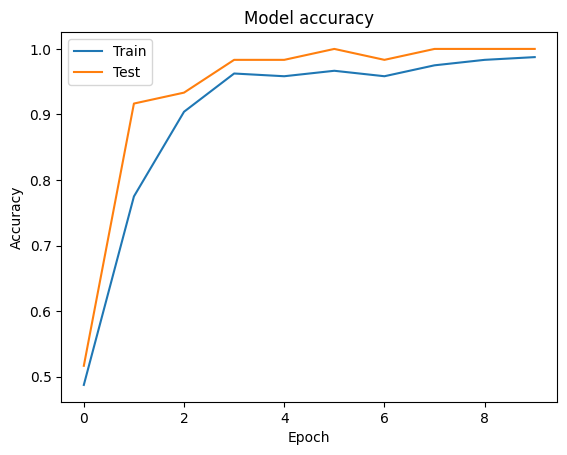

In [12]:
## acc 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

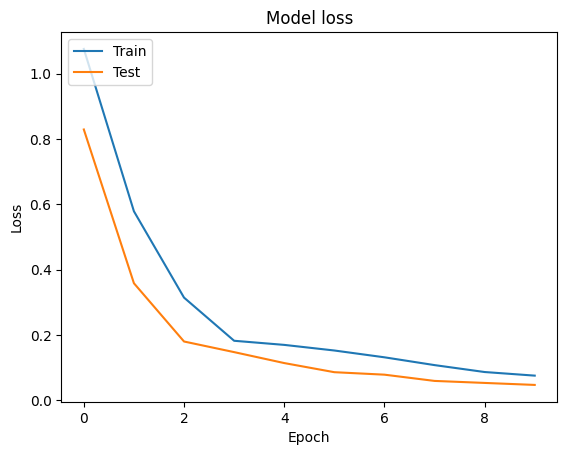

In [13]:
## loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [62]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

10/10 [==============================] - 1s 36ms/step - loss: 0.5694 - accuracy: 0.7067
Accuracy 0.7066666483879089


In [60]:
preds = model.predict(test_ds).argmax(axis=1)
targets = np.concatenate([y for x, y in test_ds], axis=0)

In [61]:
from sklearn.metrics import classification_report

preds = model.predict(test_ds).argmax(axis=1)
targets = np.concatenate([y for x, y in test_ds], axis=0)

print(classification_report(targets, preds, target_names=train_ds.class_names))

              precision    recall  f1-score   support

       paper       0.55      0.86      0.67       100
        rock       0.85      0.95      0.90       100
    scissors       1.00      0.31      0.47       100

    accuracy                           0.71       300
   macro avg       0.80      0.71      0.68       300
weighted avg       0.80      0.71      0.68       300



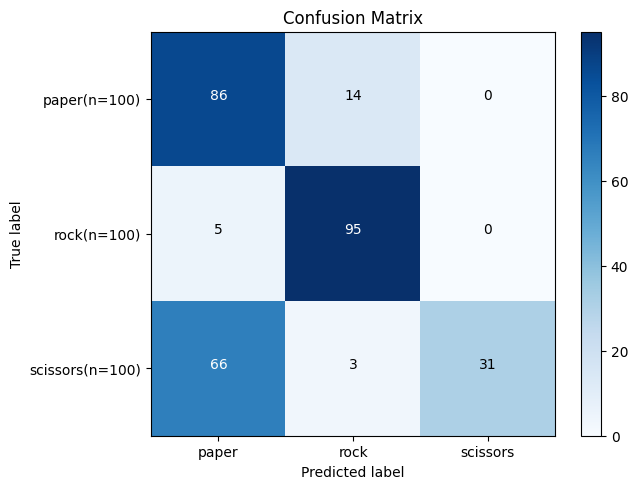

In [71]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(confusion_matrix(targets, preds), train_ds.class_names, normalize=False)

# 회고
-----

이번에는 가위바위보를 분류하는 문제를 풀었다.  
acc 60을 넘기는 조건을 만족해야하는데 training set 300개로는 쉽지 않아보이는 문제 였다.  
데이터를 보충하기 위해 먼저 data aggmentation 그러나 aggmentation만으로는 근본적 데이터 부족의 문제를 해결하여 목표치를 달성하기가 어려웠다.  
따라서 적은 데이터에도 높은 효율을 보이는 transfer learning을 도입하였고 그 결과 성공적으로 조건을 만족했다.  
좀 더 자세한 결과를 분석하기 위해 classification report와 confusion matrics를 도입했다.  
그 결과 가위를 보로 예측 하는 경우가 상당히 많아 가위와 보의 성능이 떨어진다는 것을 확인할 수 있었다.  
사진으로도 비교해봤는데 완전 다른데 ㅎ..   
가위와 보에 대한 데이터를 좀 더 확보해서 실험을 진행해볼 필요가 있는 거 같다.